In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# you can choose one of the following package for image reading/processing
import cv2
import PIL

## Problem 1: Classification Problem

In [2]:
!unzip "./EMNIST.zip" -d "./"

Archive:  ./EMNIST.zip
replace ./EMNIST/a/0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: ./EMNIST/a/0.jpg        
 extracting: ./EMNIST/a/1.jpg        
 extracting: ./EMNIST/a/10.jpg       
 extracting: ./EMNIST/a/100.jpg      
 extracting: ./EMNIST/a/101.jpg      
 extracting: ./EMNIST/a/102.jpg      
 extracting: ./EMNIST/a/103.jpg      
 extracting: ./EMNIST/a/104.jpg      
 extracting: ./EMNIST/a/105.jpg      
 extracting: ./EMNIST/a/106.jpg      
 extracting: ./EMNIST/a/107.jpg      
 extracting: ./EMNIST/a/108.jpg      
 extracting: ./EMNIST/a/109.jpg      
 extracting: ./EMNIST/a/11.jpg       
 extracting: ./EMNIST/a/110.jpg      
 extracting: ./EMNIST/a/111.jpg      
 extracting: ./EMNIST/a/112.jpg      
 extracting: ./EMNIST/a/113.jpg      
 extracting: ./EMNIST/a/114.jpg      
 extracting: ./EMNIST/a/115.jpg      
 extracting: ./EMNIST/a/116.jpg      
 extracting: ./EMNIST/a/117.jpg      
 extracting: ./EMNIST/a/118.jpg      
 extracting: ./EMNIST/a/119.jpg      

In [3]:
CLASS_NUM = 8
CLASS_EMNIST = {'a': 0, 'b': 1, 'c': 2, 'd': 3,
                'e': 4, 'f': 5, 'g': 6, 'h': 7}

In [4]:
def read_images(dataset_path):
    train_data = []
    test_data = []

    for class_name in os.listdir(dataset_path):
        print(class_name) # h, d, a, g, f, b, c, e
        file_path = dataset_path + '/' + class_name
        
        truth = np.zeros(CLASS_NUM)
        truth[CLASS_EMNIST[class_name]] = 1
        print(truth)

        data = []
        for img_name in os.listdir(file_path):
            img = PIL.Image.open(file_path + '/' + img_name)
            img = np.array(img)
            img = np.ravel(img)

            img_mean = np.mean(img)
            img_var = np.var(img)
            img = (img - img_mean) / np.sqrt(img_var)
            img = np.concatenate((img, truth))

            data.append(img)

        # Random shuffle the dataset
        # np.random.seed(1)
        np.random.shuffle(data)

        # Divide the dataset into training and testing
        train = data[32:]
        test = data[:32]

        train_data.append(train)
        test_data.append(test)
      
    return train_data, test_data

In [5]:
train_data, test_data = read_images("./EMNIST")

train_data = np.reshape(train_data, (-1, len(train_data[0][0])))
test_data = np.reshape(test_data, (-1, len(test_data[0][0])))
print('train_data', np.shape(train_data))
print('test_data', np.shape(test_data))

# Random shuffle the training and testing dataset
# np.random.seed(1)
np.random.shuffle(train_data)
np.random.shuffle(test_data)

train_x = train_data[:, :-8]
train_t = train_data[:, -8:]

test_x = test_data[:, :-8]
test_t = test_data[:, -8:]

print('train_x', np.shape(train_x))
print('train_t', np.shape(train_t))
print('test_x', np.shape(test_x))
print('test_t', np.shape(test_t))

d
[0. 0. 0. 1. 0. 0. 0. 0.]
f
[0. 0. 0. 0. 0. 1. 0. 0.]
e
[0. 0. 0. 0. 1. 0. 0. 0.]
c
[0. 0. 1. 0. 0. 0. 0. 0.]
g
[0. 0. 0. 0. 0. 0. 1. 0.]
h
[0. 0. 0. 0. 0. 0. 0. 1.]
b
[0. 1. 0. 0. 0. 0. 0. 0.]
a
[1. 0. 0. 0. 0. 0. 0. 0.]
train_data (768, 792)
test_data (256, 792)
train_x (768, 784)
train_t (768, 8)
test_x (256, 784)
test_t (256, 8)


### 1-1: Least Squares for Classification

In [6]:
class LeastSquareClassif():
    def __init__(self):
        pass
    
    # w_ls = (x_T * x)^(-1) * x_T * t
    def least_square(self, x, t):
        tmp_inv = np.linalg.pinv(np.dot(x.T, x))
        w_ls = np.dot(np.dot(tmp_inv, x.T), t)
        return w_ls

    def basis_function(self, x):
        x0 = np.ones((len(x), 1))
        x_basis_func = np.concatenate((x0, x), axis=1)
        return x_basis_func

    def mean_square_error(self, x, w, t):
        tmp = np.dot(x, w) - t
        error = np.trace(np.dot(tmp.T, tmp))
        mse = np.sqrt(np.mean(error))
        return mse

    def cross_entropy_error(self, y, t): 
        return -np.sum(t * np.log(y))

    def prediction(self, x, w):
        y = np.dot(w.T, x.T)
        return y.T

    def accuracy(self, y, t):
        class_y = np.argmax(y, axis=1)
        class_t = np.argmax(t, axis=1)
        return np.count_nonzero((class_y - class_t) == 0) / y.shape[0]

In [7]:
LS = LeastSquareClassif()

train_phi_x = LS.basis_function(train_x)
w = LS.least_square(train_phi_x, train_t)
train_loss = LS.mean_square_error(train_phi_x, w, train_t)
train_pred = LS.prediction(train_phi_x, w)
train_acc = LS.accuracy(train_pred, train_t)

test_phi_x = LS.basis_function(test_x)
test_loss = LS.mean_square_error(test_phi_x, w, test_t)
test_pred = LS.prediction(test_phi_x, w)
test_acc = LS.accuracy(test_pred, test_t)

print('Training:  loss = %.6f, accuracy = %.3f' % (train_loss, train_acc))
print('Testing:   loss = %.6f, accuracy = %.3f' %(test_loss, test_acc))

Training:  loss = 6.663312, accuracy = 1.000
Testing:   loss = 566.948867, accuracy = 0.320


### 1-2: Logistic Regression with Different Gradient Descent

In [8]:
class LogisticRegression():
    def __init__(self, train_data, test_data):
        self.train_data = train_data
        self.test_data = test_data
        self.w_list =[]

    def softmax_activation(self, a):
        sft = np.exp(a).T / np.sum(np.exp(a), axis=1).T
        return sft.T

    def gradient(self, x, y, t):
        grad = np.dot(x.T, (y - t)) # grad: (785, 8)
        return grad

    def cross_entropy_error(self, y, t): 
        return -np.sum(np.mean(t * np.log(y)))

    def hessian_matrix(self, x, y):
        # R = np.dot(y, (np.eye(y.shape[0], y.shape[1]) - y).T)
        R = np.zeros((y.shape[0], y.shape[0]))
        class_y = np.argmax(y, axis=1)
        for n in range(y.shape[0]):
            R[n][n] = y[n][class_y[n]] * (1 - y[n][class_y[n]])
        
        H = np.dot(np.dot(x.T, R), x)
        return H

    def accuracy(self, y, t):
        class_y = np.argmax(y, axis=1)
        class_t = np.argmax(t, axis=1)
        return np.sum(class_y == class_t) / y.shape[0]

    def basis_function(self, x):
        x0 = np.ones((len(x), 1))
        x_basis_func = np.concatenate((x0, x), axis=1)  # x_basis_func: (768, 785)
        return x_basis_func

    def create_mini_batches(self, data, batch_size):
        mini_batches = []
        n_minibatches = data.shape[0] // batch_size
      
        for i in range(n_minibatches):
            mini_batch = data[i * batch_size:(i + 1) * batch_size, :]
            x_mini = mini_batch[:, :-8]
            t_mini = mini_batch[:, -8:]
            mini_batches.append((x_mini, t_mini))

        if data.shape[0] % batch_size != 0:
            mini_batch = data[n_minibatches * batch_size:data.shape[0]]
            x_mini = mini_batch[:, :-8]
            t_mini = mini_batch[:, -8:]
            mini_batches.append((x_mini, t_mini))
            n_minibatches += 1

        return mini_batches

    def gradient_descent(self, mode, learning_rate=0.0001, batch_size=32, max_epoch=100):
        if mode == 'train':
            data = self.train_data
            w_list = []
        else:
            data = self.test_data
        
        w = np.zeros((len(data[0]) - CLASS_NUM + 1, CLASS_NUM))  # w: (785, 8)
        error_list = []
        error_tmp = []
        acc_list = []
        acc_tmp = []
        mini_batches = self.create_mini_batches(data, batch_size)
        
        for i in range(max_epoch):
            for j, mini_batch in enumerate(mini_batches):
                x_mini0, t_mini = mini_batch
                x_mini = self.basis_function(x_mini0)
                
                # Forward propagation
                a = np.dot(x_mini, w)  # a: (768, 8)
                y = self.softmax_activation(a)  # y: (768, 8)

                # Compute loss
                error = self.cross_entropy_error(y, t_mini)
                
                # Backward propagation
                # H_inv = np.linalg.pinv(self.hessian_matrix(x_mini, y))
                # grad = np.dot(H_inv, self.gradient(x_mini, y, t_mini))
                grad = self.gradient(x_mini, y, t_mini)
                
                # Update parameter
                if mode == 'train':
                    w = w - learning_rate * grad
                    w_list.append(w)
                else:
                    w = self.w_list[i * len(mini_batches) + j]

                error_tmp.append(error)
                acc_tmp.append(self.accuracy(y, t_mini))

            error_list.append(np.mean(error_tmp))
            acc_list.append(np.mean(acc_tmp))
            error_tmp = []
            acc_tmp = []

        if mode == 'train':
            self.w_list = w_list

        return error_list, acc_list
    
    def plot_graph(self, train_error, train_acc, test_error, test_acc):
        fig, ax = plt.subplots(1, 2)
        fig.set_size_inches(12, 4)
        ax[0].plot(train_error, label='training loss')
        ax[0].legend()
        ax[0].plot(test_error, label='testing loss')
        ax[0].legend()
        ax[0].set_title('Loss')
        ax[0].set_xlabel('epoch number')
        ax[0].set_ylabel('cross-entropy error')

        ax[1].plot(train_acc, label='training accuracy')
        ax[1].legend()
        ax[1].plot(test_acc, label='testing accuracy')
        ax[1].legend()
        ax[1].set_title('Accuracy')
        ax[1].set_xlabel('epoch number')
        ax[1].set_ylabel('accuracy')

        plt.tight_layout()
        plt.show()

[batch GD]
		Training	Testing
  Accuracy	 0.9818 	 0.75
      Loss	 0.0204 	 0.1098


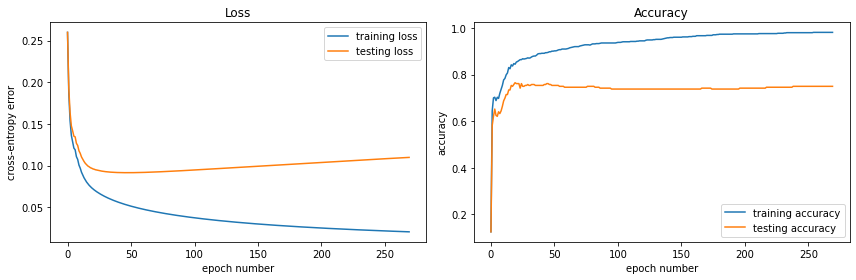


[SGD]
		Training	Testing
  Accuracy	 0.9818 	 0.7422
      Loss	 0.0206 	 0.0938


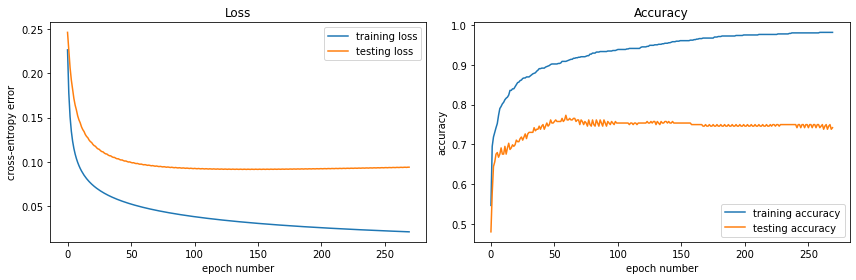


[mini-batch SGD]
		Training	Testing
  Accuracy	 0.9818 	 0.7383
      Loss	 0.0206 	 0.0936


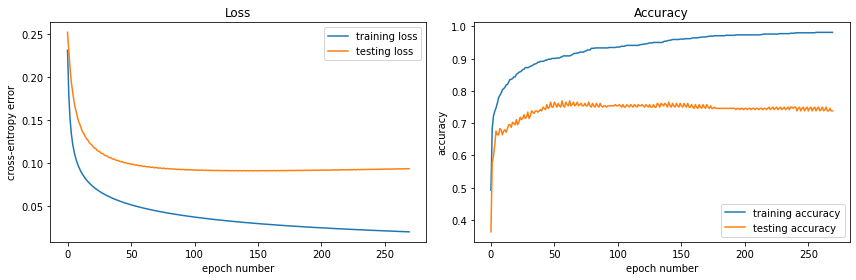

In [9]:
LR = LogisticRegression(train_data, test_data)

print('[batch GD]')
train_error, train_acc = LR.gradient_descent('train', 0.0001, len(train_data), 270)
test_error, test_acc = LR.gradient_descent('test', 0.0001, len(test_data), 270)
print('\t\tTraining\tTesting')
print('  Accuracy\t', train_acc[-1].round(4), '\t', test_acc[-1].round(4))
print('      Loss\t', train_error[-1].round(4), '\t', test_error[-1].round(4))
LR.plot_graph(train_error, train_acc, test_error, test_acc)

print('\n[SGD]')
train_error, train_acc = LR.gradient_descent('train', 0.0001, 1, 270)
test_error, test_acc = LR.gradient_descent('test', 0.0001, 1, 270)
print('\t\tTraining\tTesting')
print('  Accuracy\t', train_acc[-1].round(4), '\t', test_acc[-1].round(4))
print('      Loss\t', train_error[-1].round(4), '\t', test_error[-1].round(4))
LR.plot_graph(train_error, train_acc, test_error, test_acc)

print('\n[mini-batch SGD]')
train_error, train_acc = LR.gradient_descent('train', 0.0001, 128, 270)
test_error, test_acc = LR.gradient_descent('test', 0.0001, 128, 270)
print('\t\tTraining\tTesting')
print('  Accuracy\t', train_acc[-1].round(4), '\t', test_acc[-1].round(4))
print('      Loss\t', train_error[-1].round(4), '\t', test_error[-1].round(4))
LR.plot_graph(train_error, train_acc, test_error, test_acc)

## Problem 2: Gaussian Process for Regression

In [10]:
!unzip "./gaussian_process_data.zip" -d "./"

Archive:  ./gaussian_process_data.zip
   creating: ./gaussian_process_data/
  inflating: ./gaussian_process_data/t.csv  
  inflating: ./gaussian_process_data/x.csv  


In [11]:
data_x_ori = pd.read_csv('./gaussian_process_data/x.csv', header=None)
data_t_ori = pd.read_csv('./gaussian_process_data/t.csv', header=None)

# Turn dataset into numpy form
data_x = np.array(data_x_ori)
data_t = np.array(data_t_ori)

# Divide the dataset into training and testing
train_x = data_x[:150].reshape(-1)
test_x = data_x[150:].reshape(-1)

train_t = data_t[:150].reshape(-1)
test_t = data_t[150:].reshape(-1)

In [12]:
class GaussianProcessRegression():
    def __init__(self, train_x, train_t):
        self.train_x = train_x
        self.train_t = train_t
        self.kernel_function = 'exp_quad'
        
    def basis_function(self, x):
        bias = np.ones((len(x), 1))
        datum = np.reshape(x, (-1, 1))
        phi_x = np.concatenate((bias, datum, datum ** 2), axis=1)
        return phi_x

    def polynomial_kernel(self, xn, xm, alpha=1.0):
        phi_xn = self.basis_function(xn)
        phi_xm = self.basis_function(xm)
        return np.dot(phi_xn, phi_xm.T) / alpha

    def exponential_quadratic_kernel(self, xn, xm, theta):
        return theta[0] * np.exp(-0.5 * theta[1] * (np.subtract.outer(xn, xm) ** 2)) + theta[2] + theta[3] * np.multiply.outer(xn, xm)

    def kernel(self, xn, xm, theta):
        if self.kernel_function == 'exp_quad':
            k = self.exponential_quadratic_kernel(xn, xm, theta)
        else:
            k = self.polynomial_kernel(xn, xm)
        return k
    
    def covariance(self, x, theta, beta=1.0):
        k = self.kernel(x, x, theta)
        return k + np.identity(len(x)) / beta

    def prediction(self, data, k_func='exp_quad', theta=[1, 2, 16, 20]):
        self.kernel_function = k_func
        k = self.kernel(self.train_x, data, theta)

        cn = self.covariance(self.train_x, theta)
        c = self.covariance(data, theta)

        tmp = np.dot(k.T, np.linalg.pinv(cn))
        mean = np.dot(tmp, self.train_t)
        cov = c - np.dot(tmp, k)

        return mean, np.diag(np.sqrt(np.absolute(cov)))
    
    def plot_graph(self, data, mean, std, title):
        plt.plot(self.train_x, self.train_t, '.')
        plt.plot(data, mean.reshape(-1, 1), 'r')
        plt.fill_between(data, mean + std, mean - std, color='pink')
        plt.xlabel('x')
        plt.ylabel('t')
        plt.title(title)
        plt.show()
    
    def root_mean_square_error(self, mean, t):
        return np.sqrt(np.mean((mean - t) ** 2))

In [13]:
thetas = [[0, 0, 0, 1], [1, 8, 0, 0], [1, 1, 0, 16], [1, 1, 32, 0]]
data = np.linspace(0, 10, 150)

print('train_x', np.shape(train_x))
print('test_x', np.shape(test_x))
print('data', np.shape(data))

GP = GaussianProcessRegression(train_x, train_t)

train_x (150,)
test_x (150,)
data (150,)


### 2-3  Plot the prediction results.


> 2-1 A kernel function using the basis functions in a form of polynomial model



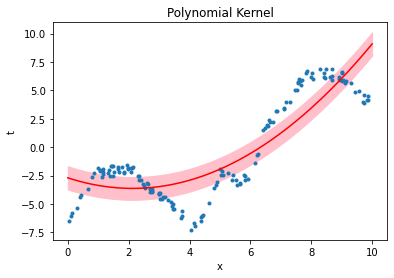

In [14]:
mean, std = GP.prediction(data, k_func='poly')
GP.plot_graph(data, mean, std, 'Polynomial Kernel')

> 2-2 An exponential-quadratic kernel function with given hyperparameters θ

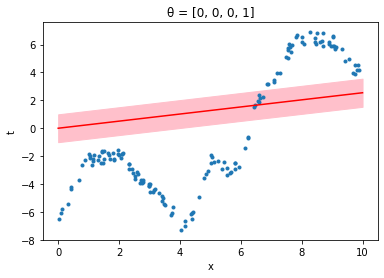

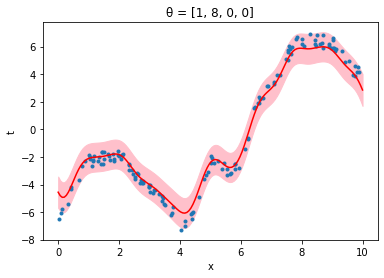

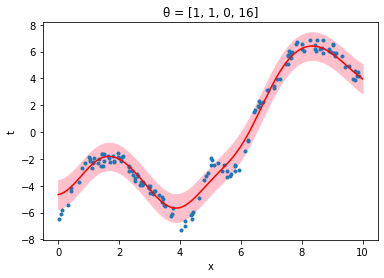

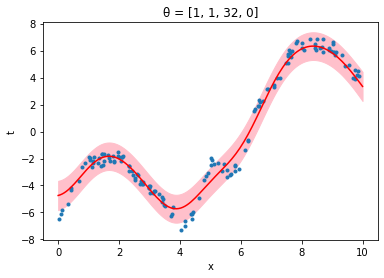

In [15]:
for the in thetas:
    mean, std = GP.prediction(data, k_func='exp_quad', theta=the)
    GP.plot_graph(data, mean, std, 'θ = ' + str(the))

### 2-4 Show the corresponding root-mean-square errors of training and testing sets.

In [16]:
mean, std = GP.prediction(train_x, k_func='poly')
train_rmse_poly = GP.root_mean_square_error(mean, train_t).round(5)

mean, std = GP.prediction(test_x, k_func='poly')
test_rmse_poly = GP.root_mean_square_error(mean, test_t).round(5)

print('Polynomial kernel:')
print('\tTraning RMSE\tTesting RMSE')
print('\t  ', train_rmse_poly, '\t  ', test_rmse_poly, '\n')

train_rmse_exp = []
for the in thetas:
    mean, std = GP.prediction(train_x, k_func='exp_quad', theta=the)
    train_rmse_exp.append(GP.root_mean_square_error(mean, train_t).round(5))

test_rmse_exp = []
for the in thetas:
    mean, std = GP.prediction(test_x, k_func='exp_quad', theta=the)
    test_rmse_exp.append(GP.root_mean_square_error(mean, test_t).round(5))

print('Exponential quadratic kernel:')
print('\tθ\t\tTraning RMSE\tTesting RMSE')
for i, theta in enumerate(thetas):
    print('  ', theta, '\t  ', train_rmse_exp[i], '\t  ', test_rmse_exp[i])

Polynomial kernel:
	Traning RMSE	Testing RMSE
	   2.06636 	   2.09713 

Exponential quadratic kernel:
	θ		Traning RMSE	Testing RMSE
   [0, 0, 0, 1] 	   4.08272 	   3.93262
   [1, 8, 0, 0] 	   0.46962 	   0.49303
   [1, 1, 0, 16] 	   0.6045 	   0.58098
   [1, 1, 32, 0] 	   0.60249 	   0.58663


### 2-5 Tune the hyperparameters θ.

> Trial and error

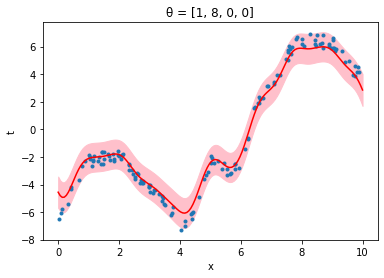

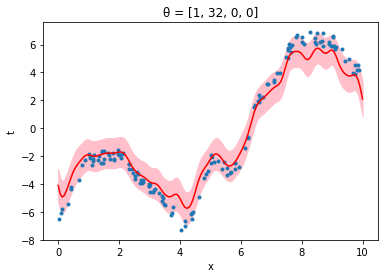

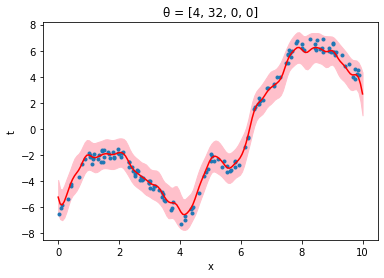

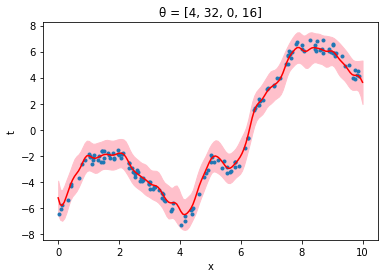

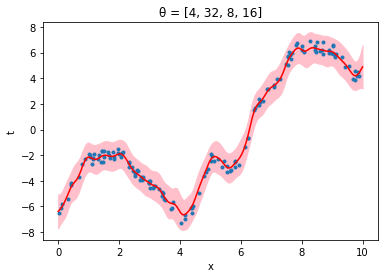

In [17]:
thetas = [[1, 8, 0, 0], [1, 32, 0, 0], [4, 32, 0, 0], [4, 32, 0, 16], [4, 32, 8, 16]]
for the in thetas:
    mean, std = GP.prediction(data, k_func='exp_quad', theta=the)
    GP.plot_graph(data, mean, std, 'θ = ' + str(the))